In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv004.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

# FENICSx imports
import ufl, dolfinx
from mpi4py import MPI

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
def print_array(**kwargs):
    for k, v in kwargs.items():
        print(f'{k} ∈ {v.dtype} {v.shape}')
        
def relative_error(u_true, u_pred):
    return np.linalg.norm(u_true - u_pred) / np.linalg.norm(u_true)

In [12]:
example.mre

<xarray.DataArray 'mre' (x: 256, y: 256, z: 4)>
[262144 values with dtype=int16]
Coordinates:
  * x        (x) float64 -0.4138 -0.411 -0.4082 -0.4054 ... 0.2978 0.3006 0.3034
  * y        (y) float64 -0.3917 -0.3889 -0.3861 ... 0.3199 0.3227 0.3255
  * z        (z) float64 -0.002113 0.01989 0.04189 0.06389
    region   (x, y, z) float32 ...

Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
{'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x14bfa497e0b0>, 'vmax': 0.006820188725704829}


<IPython.core.display.Javascript object>


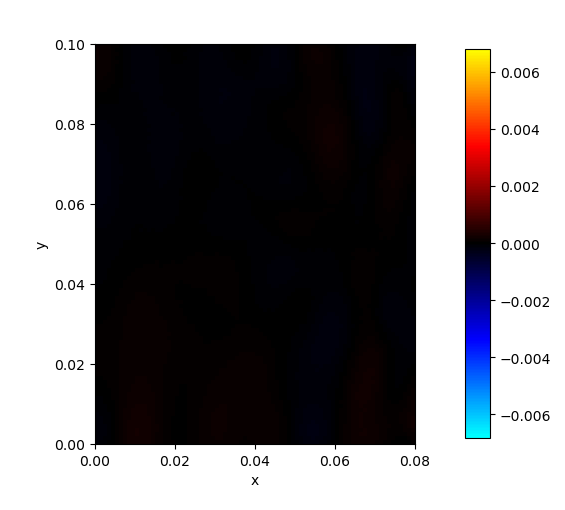

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

HERE
{'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x14bfa4939210>, 'vmax': 11000.0}


<IPython.core.display.Javascript object>


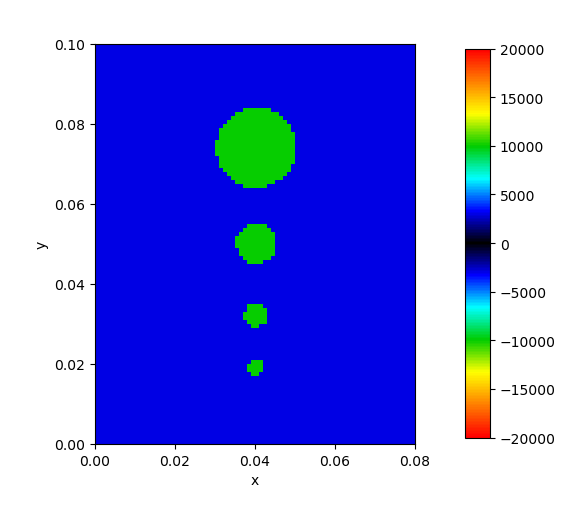

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [34]:
%autoreload
frequency = 100
#example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD/v4/', '0006') # x y
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box/', frequency) # y z
example.view('wave', mask=True)
example.view('mre', mask=True, vmax=20e3)

In [35]:
# simulation
components = ['y', 'z']
z_slice = example.wave.z[0]
wave = example.wave.sel(z=z_slice, component=components)

# patient
#wave = example.wave.sel(z=z)
#wave = xr.concat([wave, xr.zeros_like(wave)], dim=xr.DataArray(['x', 'y'], dims='component'))

Kwave = wave.field.smooth(order=2, kernel_size=3)
Jwave = wave.field.gradient(savgol=False)

mre = example.mre.sel(z=z)
ndim = wave.field.n_spatial_dims

x = wave.field.points()
u = wave.field.values()
Ku = wave.field.values()
Ju = Jwave.field.values()
mu = mre.field.values()

print_array(x=x, u=u, Ku=Ku, Ju=Ju, mu=mu)

x ∈ float64 (8000, 2)
u ∈ complex128 (8000, 2)
Ku ∈ complex128 (8000, 2)
Ju ∈ complex128 (8000, 2, 2)
mu ∈ complex128 (8000, 1)


In [36]:
# create uniform mesh
mesh = mre_pinn.baseline.fem.create_mesh_from_data(wave, align_nodes=True, mesh_scale=1)

# create FEM basis
scalar_space = dolfinx.fem.FunctionSpace(mesh, element=('DG', 1))
vector_space = dolfinx.fem.VectorFunctionSpace(mesh, element=('CG', 3), dim=ndim)
tensor_space = dolfinx.fem.TensorFunctionSpace(mesh, element=('CG', 3), shape=(ndim, ndim))

# interpolate wave field into FEM basis
u_h = dolfinx.fem.Function(vector_space)
u_h.interpolate(mre_pinn.baseline.fem.create_func_from_data(wave))

# interpolate Jacobian into FEM basis
Ju_h = dolfinx.fem.Function(tensor_space)
Ju_h.interpolate(mre_pinn.baseline.fem.create_func_from_data(Jwave))

In [44]:
help(ufl.TrialFunctions)

Help on function TrialFunctions in module ufl.argument:

TrialFunctions(function_space)
    UFL value: Create a TrialFunction in a mixed space, and return a
    tuple with the function components corresponding to the subelements.



In [41]:
# reconstruct elasticity field

# define physical constants
rho = 1000
omega = 2 * np.pi * 40

# set up and solve variational problem
mu_h, p_h = ufl.TrialFunctions(scalar_space * scalar_space)
v_h, q_h = ufl.TestFunctions(vector_space * scalar_space)

#A = mu_h * ufl.inner(ufl.grad(u_h), ufl.grad(v_h)) * ufl.dx

Du_h = Ju_h + ufl.transpose(Ju_h)
A = mu_h * ufl.inner(Du_h, ufl.grad(v_h)) * ufl.dx
#A -= ufl.inner(ufl.grad(mu_h), Ju_h * v_h) * ufl.dx # hetero
A += p

b = rho * omega**2 * ufl.inner(u_h, v_h) * ufl.dx

problem = dolfinx.fem.petsc.LinearProblem(
    A, b, bcs=[], petsc_options={'ksp_type': 'lsqr', 'pc_type': 'none'}
)
mu_h, p_h = problem.solve()

# evaluate reconstructed elasticity field
mu_pred = mre_pinn.baseline.fem.eval_dolfinx_func(mu_h, x)

HERE
{'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x14bfa492d780>, 'vmax': 1020.022242785566}


<IPython.core.display.Javascript object>


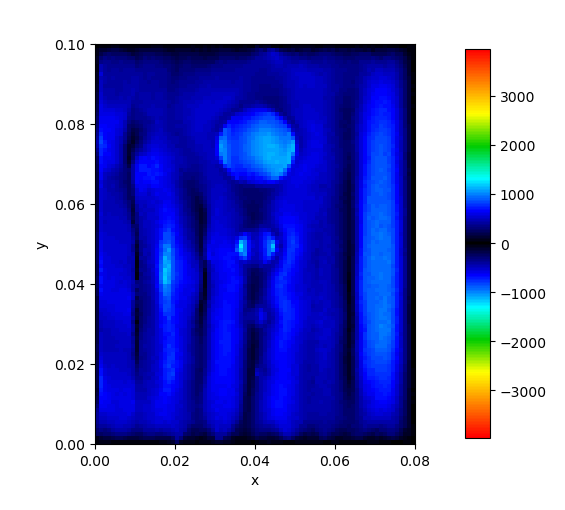

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [42]:
mre_pred = mre_pinn.utils.as_xarray(mu_pred.reshape(mre.shape), like=mre)
mre_pred.name = 'mre'
mre_pinn.visual.XArrayViewer(mre_pred, vmax=5e3, polar=True)